In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
import gpzoo
from gpzoo.kernels import NSF_RBF, batched_RBF
from gpzoo.gp import GaussianPrior, SVGP, VNNGP
from gpzoo.likelihoods import PNMF, NSF2, Hybrid_NSF2, GaussianLikelihood
from gpzoo.utilities import train_hybrid, train_hybrid_batched, anndata_to_train_val, plot_factors, rescale_spatial_coords, add_jitter, init_softplus
import squidpy as sq
import numpy as np
from sklearn.decomposition import NMF
import scanpy as sc
import random

from gpzoo.utilities import regularized_nmf, dims_autocorr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import pickle
from sklearn.cluster import KMeans

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):

    max_val = np.percentile(factors, 95)
    min_val = np.percentile(factors, 5)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
        
    for i in range(L):
        
        
        curr_ax = ax[i//5, i%5]
        
        
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [3]:
adata = sq.datasets.slideseqv2()
adata = adata.raw.to_adata()

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


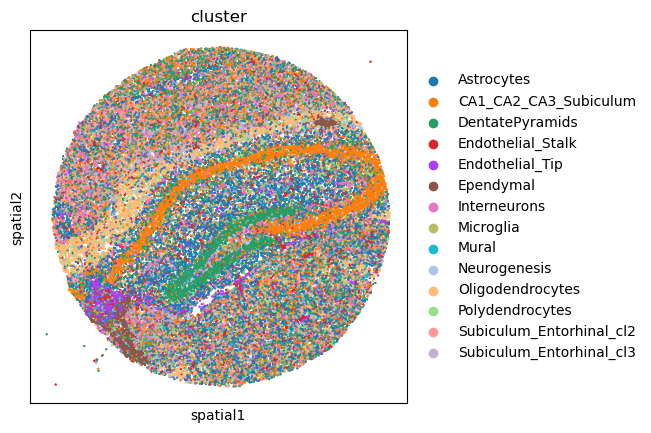

In [4]:
sq.pl.spatial_scatter(adata, color="cluster", size=1, shape=None);


<Axes: >

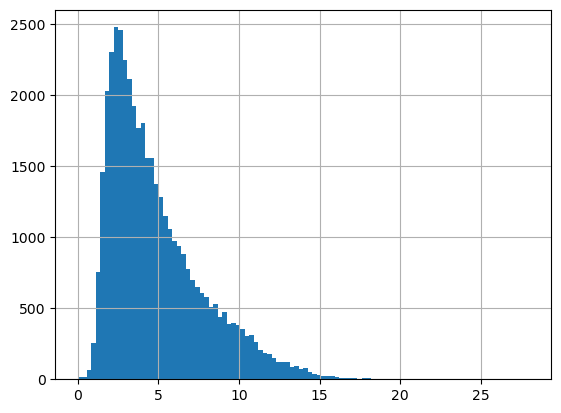

In [5]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata.obs.pct_counts_mt.hist(bins=100)


In [6]:
adata = adata[adata.obs.pct_counts_mt < 20] #from 53K to 45K
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=10)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


In [7]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [8]:
Dtr, Dval = anndata_to_train_val(adata, sz="scanpy")

In [9]:
Y = Dtr['Y'].T
Y = Y[~adata.var.MT]
X = Dtr['X']*50
V = Dtr['sz']

In [10]:
Y.shape

(17702, 39694)

In [12]:
factors, loadings = regularized_nmf(Y.T/V, L=20, shrinkage=0.3, max_iter = 1000, solver='mu', init='nndsvdar', beta_loss='kullback-leibler', random_state=997)

In [13]:
moran_idx, moranI = dims_autocorr(np.exp(factors), X)

here_andata


In [14]:
# moranI

In [15]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

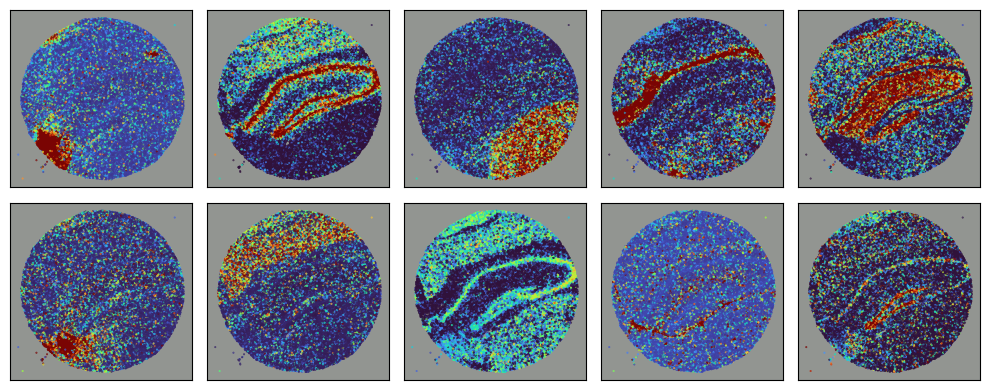

In [16]:
plot_factors(np.exp(factors.T), X, moran_idx=moran_idx[0:10], ax=None, size=2, s=0.2, alpha=0.9)

In [18]:
X = torch.tensor(X).type(torch.float)
Y = torch.tensor(factors_ordered[:, :10].T).type(torch.float)

/tmp/ipykernel_2609241/740467001.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).type(torch.float)


In [46]:
def build_model_scracth(Y, M=1000, L=10):
    

    
    # idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)

    kmeans = KMeans(n_clusters=M, random_state=240, n_init="auto").fit(X)
    Z = nn.Parameter(torch.tensor(kmeans.cluster_centers_).type(torch.float))
    
    kernel = batched_RBF(sigma=[1.0]*L, lengthscale=[2.0]*L)
    gp = SVGP(kernel, M=M, jitter=1e-2)


    Kzx = kernel.forward(Z, X)
    Kxz = torch.transpose(Kzx, -2, -1)
    Kzz = kernel.forward(Z, Z)


    all_factors = torch.tensor(factors_ordered.T)[:L, :, None].type(torch.float)
    L1 = torch.linalg.cholesky(add_jitter(Kzx@Kxz, 1e-5))
    

    solved1 = torch.cholesky_solve(Kzx@all_factors, L1)
    print('solved1 shape:', solved1.shape)

    mu = Kzz@solved1
    
    gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float)
    Lu = 1e-2*torch.eye(M).expand(L, M, M)
    gp.Lu = nn.Parameter(Lu.clone().detach())
    gp.Z = nn.Parameter(Z, requires_grad=False)

    

    

    model = GaussianLikelihood(gp, noise=0.1)
    
    model.to(device)
    return model

In [47]:
model = build_model_scracth(Y, M=3000)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fef6fe728b0>
Traceback (most recent call last):
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has n

solved1 shape: torch.Size([10, 3000, 1])


In [21]:
X_train = X.to(device)
Y_train = Y.to(device)

In [48]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [49]:
def train_batched(model, optimizer, X, y, device, steps=200, E=20, batch_size=1000, **kwargs):
    losses = []
    
    means = []
    scales = []
    idxs = []
    
    for it in tqdm(range(steps)):
        
        idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=batch_size, replacement=False)
        
        
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X=X[idx], E=E, **kwargs)

        logpY = pY.log_prob(y[:, idx])

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        
        loss = -ELBO
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if (it%10)==0:
            idxs.append(idx.detach().cpu().numpy())
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales, idxs

In [105]:
steps = 1000*8*2
model.to(device)

GaussianLikelihood(
  (gp): SVGP(
    (kernel): batched_RBF()
  )
)

In [106]:
model.gp.jitter=1e-3

In [ ]:
losses, means, scales, idxs = train_batched(model, optimizer, X_train, Y_train, device, steps=steps, E=3,  batch_size=7000)

  0%|          | 0/16000 [00:00<?, ?it/s]

In [89]:
# torch.save(model.state_dict(), 'slideseq_nsf_3000.pth')

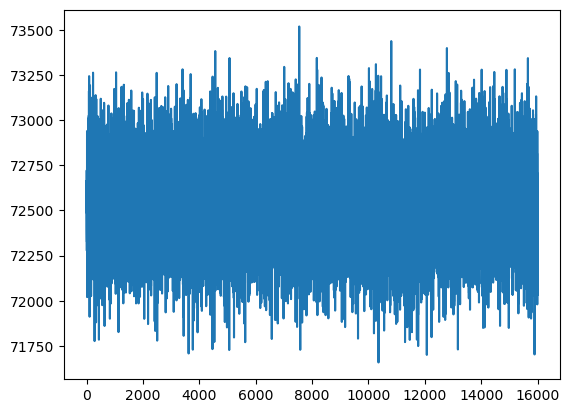

In [108]:
plt.plot(losses)

In [109]:
model.gp.kernel.lengthscale

Parameter containing:
tensor([20.7901, 10.8876, 20.5246, 11.5915,  7.6334, 23.4212, 21.6114,  9.4823,
        19.4851,  9.8826], device='cuda:1', requires_grad=True)

In [110]:
model.gp.kernel.sigma

Parameter containing:
tensor([1.9947, 2.0537, 1.9514, 2.0049, 2.0408, 1.9486, 1.9252, 2.0843, 1.9356,
        1.9677], device='cuda:1', requires_grad=True)

In [113]:
torch.nn.functional.softplus(model.noise)

tensor(0.6448, device='cuda:1', grad_fn=<SoftplusBackward0>)

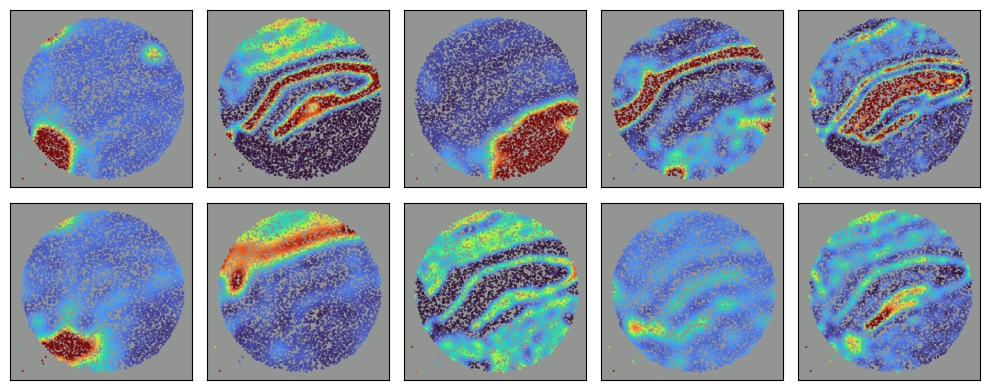

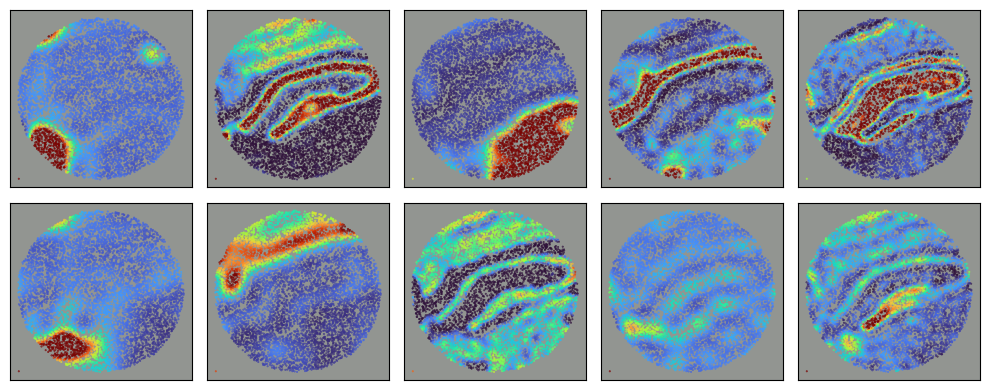

In [112]:
plot_factors(means[0], X[idxs[0]], moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)
plot_factors(means[-1], X[idxs[-1]], moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)


In [ ]:
# size=2
# fig, ax = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)


# def update(iteration):
#     for element in ax:
#         for element in element:
#             element.cla()
        
#     curr_factor = means[iteration]

    
    
#     plot_factors(curr_factor, X, ax=ax, size=2, s=0.6, alpha=1)

# #     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
# #     fig.tight_layout()
#     print('hi', iteration)


# anim = FuncAnimation(fig, update, frames=np.arange(0, 600, 1), interval=100)
# plt.close()z
# # anim.save('pnmf.mp4',
# #          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
# #          dpi=50)
# anim.save("visium_vnngp.mp4", fps=60, dpi=100)